<a href="https://colab.research.google.com/github/Aravindh4404/FYPSeagullClassification01/blob/main/G_Karpathy_HQSBNGW_2410.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
import numpy as np
import random

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Mount Google Drive to save and load the model
from google.colab import drive
drive.mount('/content/drive')

# Define the folder to save model checkpoints
checkpoint_folder = '/content/drive/My Drive/FYP/ModelCheckpointsHQ/'
os.makedirs(checkpoint_folder, exist_ok=True)

# Data Augmentation for Training Set
transform_train = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.RandomHorizontalFlip(),  # Augmentation: Random horizontal flip
    transforms.RandomRotation(15),      # Augmentation: Random rotation
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),  # Augmentation: Color jitter
    transforms.ToTensor(),              # Convert to tensor
])

# Simple resizing for validation and test sets
transform_val_test = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.ToTensor(),
])

# Data preparation: Training, Validation, and Test sets
data_path = '/content/drive/My Drive/FYP/Dataset/HQSBNGW/train'
test_data_path = '/content/drive/My Drive/FYP/Dataset/HQSBNGW/test'

# Load datasets
train_dataset = datasets.ImageFolder(data_path, transform=transform_train)
test_dataset = datasets.ImageFolder(test_data_path, transform=transform_val_test)

# Split the dataset into 80% training and 20% validation
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# Create data loaders
batch_size = 16  # Use a larger batch size for better stability
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Use Pre-trained ResNet50 model and modify it for binary classification
class ResNet50Modified(nn.Module):
    def __init__(self):
        super(ResNet50Modified, self).__init__()
        self.resnet = models.resnet50(pretrained=True)
        # Replace the final fully connected layer to output 2 classes (Slaty-backed, Glaucous-winged)
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Sequential(
            nn.Dropout(0.5),  # Add dropout to the fully connected layer
            nn.Linear(num_ftrs, 2)
        )

    def forward(self, x):
        return self.resnet(x)

# Initialize the ResNet50 model
model = ResNet50Modified()

# Define loss function and optimizer with L2 regularization (weight decay)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)  # L2 regularization with weight decay

# Learning rate scheduler to reduce learning rate if validation accuracy plateaus
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=3, verbose=True)

# Early stopping class to monitor validation accuracy
class EarlyStopping:
    def __init__(self, patience=5, verbose=False):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_acc = None
        self.early_stop = False

    def __call__(self, val_acc, model, folder_path):
        if self.best_acc is None:
            self.best_acc = val_acc
            self.save_model(model, folder_path)
        elif val_acc <= self.best_acc:
            self.counter += 1
            if self.counter >= self.patience:
                if self.verbose:
                    print("Early stopping triggered!")
                self.early_stop = True
        else:
            self.best_acc = val_acc
            self.save_model(model, folder_path)
            self.counter = 0

    def save_model(self, model, folder_path):
        model_save_path = os.path.join(folder_path, "best_model2310.pth")
        torch.save(model.state_dict(), model_save_path)
        print(f"Best model saved with accuracy: {self.best_acc:.4f}% at {model_save_path}")

# Initialize early stopping
early_stopping = EarlyStopping(patience=5, verbose=True)

# Training loop with early stopping and learning rate scheduler
def train(model, train_loader, val_loader, criterion, optimizer, scheduler, early_stopping, epochs=20):
    best_val_acc = 0.0  # Initialize the best validation accuracy

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # Print the loss per epoch
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.6f}")

        # Validate the model and check accuracy
        val_acc = validate(model, val_loader, criterion)
        scheduler.step(val_acc)

        # Early stopping checks
        early_stopping(val_acc, model, checkpoint_folder)

        if early_stopping.early_stop:
            print("Early stopping - training stopped")
            break

# Validation loop returning accuracy
def validate(model, loader, criterion):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Validation Loss: {val_loss/len(loader):.6f}, Accuracy: {accuracy:.2f}%')
    return accuracy  # Return accuracy to track the best model

# Test function to evaluate on the test set
def test(model, loader, criterion):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Test Loss: {test_loss/len(loader):.6f}, Test Accuracy: {accuracy:.2f}%')

# Run the full code sequence

# Step 1: Train the model with early stopping and learning rate scheduling
train(model, train_loader, val_loader, criterion, optimizer, scheduler, early_stopping, epochs=20)

# Step 2: Evaluate the model on the test set
test(model, test_loader, criterion)


Mounted at /content/drive


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 181MB/s]
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

Epoch [1/20], Loss: 0.506965
Validation Loss: 0.432936, Accuracy: 74.68%
Best model saved with accuracy: 74.6835% at /content/drive/My Drive/FYP/ModelCheckpointsHQ/best_model2310.pth
Epoch [2/20], Loss: 0.428223
Validation Loss: 5.682191, Accuracy: 58.23%
Epoch [3/20], Loss: 0.379863
Validation Loss: 3.583584, Accuracy: 78.48%
Best model saved with accuracy: 78.4810% at /content/drive/My Drive/FYP/ModelCheckpointsHQ/best_model2310.pth
Epoch [4/20], Loss: 0.477553
Validation Loss: 2.443933, Accuracy: 76.58%
Epoch [5/20], Loss: 0.344798
Validation Loss: 0.277179, Accuracy: 89.24%
Best model saved with accuracy: 89.2405% at /content/drive/My Drive/FYP/ModelCheckpointsHQ/best_model2310.pth
Epoch [6/20], Loss: 0.295933
Validation Loss: 0.748174, Accuracy: 75.32%
Epoch [7/20], Loss: 0.335352
Validation Loss: 0.202918, Accuracy: 90.51%
Best model saved with accuracy: 90.5063% at /content/drive/My Drive/FYP/ModelCheckpointsHQ/best_model2310.pth
Epoch [8/20], Loss: 0.284356
Validation Loss: 0.2

In [1]:
import torch
import torch.nn as nn  # Add this line to avoid the NameError
from torchvision import transforms, models
from PIL import Image
import os

# Mount Google Drive to save and load the model
from google.colab import drive
drive.mount('/content/drive')

# Define the path to the saved model and the specific image
checkpoint_path = '/content/drive/My Drive/FYP/ModelCheckpointsHQ/best_model2310.pth'
image_path = '/content/007.jpg'  # Change to your specific image path

# Define the transformation for the image (must match the test set transformations)
transform = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.ToTensor(),
])

# Load the saved model
class ResNet50Modified(nn.Module):
    def __init__(self):
        super(ResNet50Modified, self).__init__()
        self.resnet = models.resnet50(pretrained=True)
        # Replace the final fully connected layer to output 2 classes (Slaty-backed, Glaucous-winged)
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Sequential(
            nn.Dropout(0.5),  # Add dropout to the fully connected layer
            nn.Linear(num_ftrs, 2)
        )

    def forward(self, x):
        return self.resnet(x)

# Initialize and load the saved model
model = ResNet50Modified()
model.load_state_dict(torch.load(checkpoint_path, map_location=torch.device('cpu')))
model.eval()

print(f"Model loaded from {checkpoint_path}")

# Function to preprocess and load a single image
def preprocess_image(image_path):
    """Load an image and apply transformations."""
    image = Image.open(image_path).convert("RGB")
    image = transform(image)  # Apply the defined transformations
    image = image.unsqueeze(0)  # Add a batch dimension
    return image

# Manually set class names based on your dataset structure (adjust if different)
class_names = ['Glaucous_Winged_Gull', 'Slaty_Backed_Gull']  # Replace with the actual names if different

# Function to predict the class of the given image
def predict_image(model, image_tensor, class_names):
    """Predict the class of an image using the trained model."""
    with torch.no_grad():
        outputs = model(image_tensor)
        _, predicted = torch.max(outputs, 1)
        return class_names[predicted.item()]

# Preprocess the image
image_tensor = preprocess_image(image_path)

# Predict the class of the image
predicted_class = predict_image(model, image_tensor, class_names)
print(f"Predicted class: {predicted_class}")



Mounted at /content/drive


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 156MB/s]
<ipython-input-1-90eb2aedde16>:38: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possi

Model loaded from /content/drive/My Drive/FYP/ModelCheckpointsHQ/best_model2310.pth
Predicted class: Slaty_Backed_Gull


In [2]:
import torch
import torch.nn as nn
from torchvision import transforms, models, datasets
from PIL import Image
import os

# Mount Google Drive to save and load the model
from google.colab import drive
drive.mount('/content/drive')

# Define the path to the saved model and the specific image
checkpoint_path = '/content/drive/My Drive/FYP/ModelCheckpointsHQ/best_model2310.pth'
image_path = '/content/007.jpg'  # Replace with the actual image file

# Define the transformation for the image (must match the test set transformations)
transform = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.ToTensor(),
])

# Load the saved model
class ResNet50Modified(nn.Module):
    def __init__(self):
        super(ResNet50Modified, self).__init__()
        self.resnet = models.resnet50(pretrained=True)
        # Replace the final fully connected layer to output 2 classes (Slaty-backed, Glaucous-winged)
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Sequential(
            nn.Dropout(0.5),  # Add dropout to the fully connected layer
            nn.Linear(num_ftrs, 2)
        )

    def forward(self, x):
        return self.resnet(x)

# Initialize and load the saved model
model = ResNet50Modified()
model.load_state_dict(torch.load(checkpoint_path, map_location=torch.device('cpu')))
model.eval()

print(f"Model loaded from {checkpoint_path}")

# Function to preprocess and load a single image
def preprocess_image(image_path):
    """Load an image and apply transformations."""
    image = Image.open(image_path).convert("RGB")
    image = transform(image)  # Apply the defined transformations
    image = image.unsqueeze(0)  # Add a batch dimension
    return image

# Retrieve class names directly from the training dataset directory
data_path = '/content/drive/My Drive/FYP/Dataset/Original_Adult_In-flight/train'
temp_dataset = datasets.ImageFolder(data_path)
class_names = list(temp_dataset.class_to_idx.keys())
print(f"Class names: {class_names}")

# Function to predict the class of the given image
def predict_image(model, image_tensor, class_names):
    """Predict the class of an image using the trained model."""
    with torch.no_grad():
        outputs = model(image_tensor)
        _, predicted = torch.max(outputs, 1)
        return class_names[predicted.item()]

# Preprocess the image
image_tensor = preprocess_image(image_path)

# Predict the class of the image
predicted_class = predict_image(model, image_tensor, class_names)
print(f"Predicted class: {predicted_class}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<ipython-input-2-23773d4ccd97>:38: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint_path, map_location=torch.device('cpu')))


Model loaded from /content/drive/My Drive/FYP/ModelCheckpointsHQ/best_model2310.pth
Class names: ['Glaucous_Winged_Gull', 'Slaty_Backed_Gull']
Predicted class: Slaty_Backed_Gull


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<ipython-input-10-e350203d1453>:41: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint_path, map_location=torch.device('cpu')))


Model loaded from /content/drive/My Drive/FYP/ModelCheckpointsHQ/best_model2310.pth
Class names: ['Glaucous_Winged_Gull', 'Slaty_Backed_Gull']


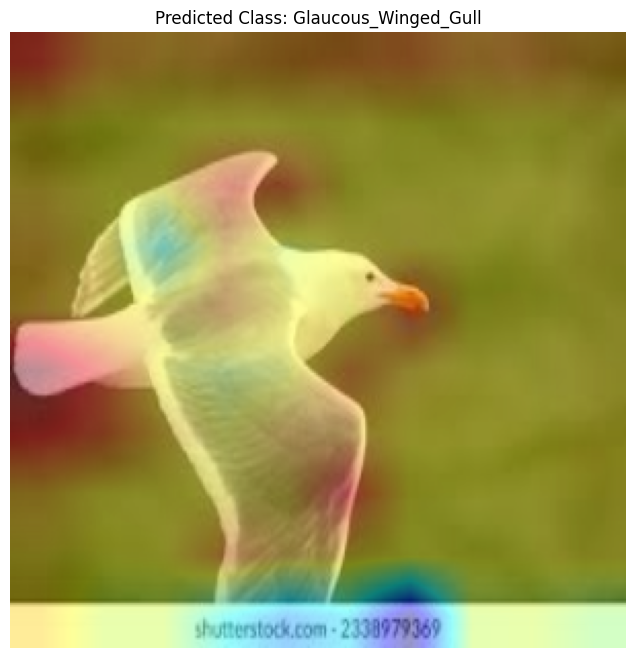

In [10]:
import torch
import torch.nn as nn
from torchvision import transforms, models, datasets
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os

# Mount Google Drive to save and load the model
from google.colab import drive
drive.mount('/content/drive')

# Define the path to the saved model and the specific image
checkpoint_path = '/content/drive/My Drive/FYP/ModelCheckpointsHQ/best_model2310.pth'
image_path = '/content/xfg.jpg'

# Define the transformation for the image (must match the test set transformations)
transform = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.ToTensor(),
])

# Load the saved model
class ResNet50Modified(nn.Module):
    def __init__(self):
        super(ResNet50Modified, self).__init__()
        self.resnet = models.resnet50(pretrained=True)
        # Replace the final fully connected layer to output 2 classes (Slaty-backed, Glaucous-winged)
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Sequential(
            nn.Dropout(0.5),  # Add dropout to the fully connected layer
            nn.Linear(num_ftrs, 2)
        )

    def forward(self, x):
        return self.resnet(x)

# Initialize and load the saved model
model = ResNet50Modified()
model.load_state_dict(torch.load(checkpoint_path, map_location=torch.device('cpu')))
model.eval()

print(f"Model loaded from {checkpoint_path}")

# Function to preprocess and load a single image
def preprocess_image(image_path):
    """Load an image and apply transformations."""
    image = Image.open(image_path).convert("RGB")
    image = transform(image)  # Apply the defined transformations
    image = image.unsqueeze(0)  # Add a batch dimension
    return image

# Retrieve class names directly from the training dataset directory
data_path = '/content/drive/My Drive/FYP/Dataset/HQSBNGW/train'
temp_dataset = datasets.ImageFolder(data_path)
class_names = list(temp_dataset.class_to_idx.keys())
print(f"Class names: {class_names}")

# Function to generate Grad-CAM heatmap and show the predicted class
def generate_gradcam(model, image_tensor, target_layer, class_names):
    # Forward pass
    model.eval()
    features = []
    grads = []

    def save_features_hook(module, input, output):
        features.append(output)

    def save_grads_hook(module, grad_in, grad_out):
        grads.append(grad_out[0])

    # Register hooks
    hook1 = target_layer.register_forward_hook(save_features_hook)
    hook2 = target_layer.register_backward_hook(save_grads_hook)

    # Forward pass
    output = model(image_tensor)
    predicted_class_idx = output.argmax().item()
    predicted_class = class_names[predicted_class_idx]

    # Backward pass to get gradients
    model.zero_grad()
    class_loss = output[0, predicted_class_idx]
    class_loss.backward()

    # Get gradients and feature maps
    gradient = grads[0].cpu().data.numpy()[0]
    feature_map = features[0].cpu().data.numpy()[0]

    # Calculate Grad-CAM
    weights = np.mean(gradient, axis=(1, 2))  # Global average pooling of the gradients
    cam = np.zeros(feature_map.shape[1:], dtype=np.float32)

    for i, w in enumerate(weights):
        cam += w * feature_map[i]

    cam = np.maximum(cam, 0)  # ReLU to remove negative values
    cam = cv2.resize(cam, (image_tensor.shape[3], image_tensor.shape[2]))
    cam -= np.min(cam)
    cam /= np.max(cam)

    # Convert original image to show on heatmap
    original_image = image_tensor.squeeze().permute(1, 2, 0).cpu().numpy()
    original_image = original_image - np.min(original_image)
    original_image = original_image / np.max(original_image)

    # Create heatmap
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam_image = 0.4 * heatmap + 0.6 * original_image

    # Show the image with the predicted class name
    plt.figure(figsize=(8, 8))
    plt.title(f"Predicted Class: {predicted_class}")
    plt.imshow(cam_image)
    plt.axis('off')
    plt.show()

    # Remove hooks
    hook1.remove()
    hook2.remove()

# Use the final layer to see which parts of the image are activated
target_layer = model.resnet.layer4[-1]

# Preprocess the image
image_tensor = preprocess_image(image_path)

# Generate Grad-CAM for the specific image and show the predicted class
generate_gradcam(model, image_tensor, target_layer, class_names)
